# Курсовая работа на тему: __Разработка автоматической диалоговой системы на основе языковой модели в сфере бизнес-аналитики__



---



Автор: `Кызыл-оол Монгун-Ай ПМ22-6`

__Цель проекта__: Разработка диалоговой системы, способной анализировать данные в сфере бизнес-аналитики: текстовые финансовые отчёты, извлекать таблицы, отвечать на вопросы пользователя и визуализировать данные в виде графиков.

In [ ]:
import openai
from openai import OpenAI
import fitz
import re
import matplotlib.pyplot as plt
import pandas as pd
import textwrap

Подключаемся к локально запущенной языковой модели через API (используется LM Studio)

In [ ]:
openai.api_key = "lm-studio"
openai.api_base = "http://localhost:1234/v1"

client = OpenAI(
    api_key="lm-studio",
    base_url="http://localhost:1234/v1"
)

Создание клиента OpenAI, тестирую модель gemma через простой вызов к языковой модели



`ask_gemma_simple` функция взаимодействия с моделью

-принимает промпт пользователя, системный промпт и параметры генерации

-формирует сообщения для модели

-отправляет запрос к языковой модели Gemma

-возвращает сгенерированный ответ

In [ ]:
def ask_gemma_simple(prompt=None,m=None,sys_prompt=None,temperature=0.3,max_tokens=10_000):
    if sys_prompt:
        messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt}
            ]
    else:
        messages=[{"role": "user", "content": prompt}]

    if m:
        messages=m

    response = client.chat.completions.create(
        model="gemma:3-12b-it-qat",
        messages=messages,
        temperature=temperature,
        max_tokens=max_tokens
    )
    return response.choices[0].message.content

reply = ask_gemma_simple("Привет! Объясни, что такое EBITDA простыми словами.",
                         sys_prompt='Отвечай в стихах и не больше 5 предложений',max_tokens=1000)
print("Ответ модели:\n", reply)

Ответ модели:
 Приветствую я вас, друг мой милый!
EBITDA – показатель умелый.
Прибыль без процентов, налогов, износа,
Арендной платы – вот его основа.
Полезен он для бизнеса, как компас!


#### Определение намерений пользователя
эта функция анализирует сообщение пользователя и определяет:

- нужно ли строить график (< CALL >)

- нужно ли искать информацию в базе данных (< SEARCH >)

для вывода ответа используется `ask_gemma_simple`, которому передается системный промпт

In [ ]:
def get_intent(message):
    sys_prompt="""Ты — помощник, который должен определить, что хочет пользователь, по его сообщению.
    У тебя есть два параметра, которые нужно установить:\n\n
    <CALL> — если пользователь явно просит построить график, установи <CALL> = 1, иначе <CALL> = 0.\n
    <SEARCH> — если пользователь прямо указывает, что нужно что-то найти в базе данных
    (например: 'найди', 'проверь в базе', 'покажи информацию о...'), установи <SEARCH> = 1, иначе <SEARCH> = 0.\n\n
    Ты должен вернуть ответ только в следующем формате:\n<CALL> = [0 или 1]\n<SEARCH> = [0 или 1]\n\n

    Примеры:\n- Пользователь: 'Построй график продаж за месяц' → <CALL> = 1, <SEARCH> = 0\n
    - Пользователь: 'Найди сотрудника по фамилии Петров' → <CALL> = 0, <SEARCH> = 1\n
    - Пользователь: 'Покажи информацию о клиенте Иванов' → <CALL> = 0, <SEARCH> = 1\n
    - Пользователь: 'Сколько было заказов в марте?' → <CALL> = 0, <SEARCH> = 0\n\n

    Теперь проанализируй следующее сообщение пользователя и верни ответ в указанном формате:"""

    res=ask_gemma_simple(message,sys_prompt=sys_prompt,max_tokens=20)
    return res

In [ ]:
print(get_intent('Привет найди в базе информацию о бизнес аналитике'))
print('-'*100)
print(get_intent('Привет построй график прибыли и налогов'))
print('-'*100)
print(get_intent('Привет как дела?'))

<CALL> = 0
<SEARCH> = 1
----------------------------------------------------------------------------------------------------
<CALL> = 1
<SEARCH> = 0

----------------------------------------------------------------------------------------------------
<CALL> = 0
<SEARCH> = 0



### Работа с данными

Обработка и преобразование JSON из ответа

Прошу модель, чтобы она переформатировала данные: вместо отдельных показателей с годами в названии → сделать нормальную таблицу (год, показатель, значение)

`extract_and_send_json_for_fix(json_text)` — исправление "кривого" JSON

если LLM выдала плохой формат JSON, эта функция передаёт его обратно в модель, просит исправить структуру в табличный формат для pandas.DataFrame

возвращается валидный JSON внутри < json >...< /json>.

In [ ]:
def extract_and_send_json_for_fix(json_text):
    messages = [
        {
            "role": "system",
            "content": """Приведи следующий JSON в корректную табличную форму для pandas.DataFrame:

- Годы (например, 2022, 2023 и т.д.) должны быть значениями в колонке "Год", то есть располагаться по строкам.
- Показатели (например, "Выручка", "Расходы", "Прибыль") должны быть отдельными колонками.
- Не используй суффиксы в названиях показателей (например, не "Выручка_2022").
- Если в изначальном тексте года указаны как суффиксы — исправь это.
- Убедись, что структура таблицы логична: каждая строка — это один год, а колонки — это разные экономические показатели.
- Верни строго валидный JSON без ошибок.
- Не добавляй никаких пояснений.
- Весь ответ должен быть строго внутри одного блока <json>...</json>.
Вот пример:
"""
        },
        {
            "role": "system",
            "content": """<json>
{
  "Финансовые_показатели": [
    {"Год": 2019, "Выручка": 125, "Расходы": 92, "Прибыль": 33},
    {"Год": 2020, "Выручка": 138, "Расходы": 100, "Прибыль": 38}
  ]
}
</json>"""
        },
        {
            "role": "user",
            "content": json_text
        }
    ]

    return ask_gemma_simple(m=messages)


убирает лишние символы (markdown, кавычки) и парсит строку в JSON

In [ ]:
import json
import pandas as pd
import re

def clean_and_parse_json_block(text):
    cleaned = re.sub(r"```json|```", "", text).strip()
    parsed = json.loads(cleaned)
    return parsed

### Контекстный ответ с извлечением данных

Основная функция для работы с бизнес-аналитикой:

Принимает вопрос пользователя и контекст (например, финансовый отчет)

Анализирует текст на наличие числовых данных

Формирует ответ с извлеченными данными в формате JSON

Возвращает текстовый ответ и DataFrame с данными

In [ ]:
def ask_with_context(message, context=None):
    import re
    import pandas as pd

    need_df = 0
    err = 0

    messages = []

    messages.append({
        "role": "system",
        "content": (
            "Ты — ассистент по бизнес-аналитике. Отвечай строго по предоставленному тексту, "
            "если он есть. Если в нём есть числовые или табличные данные (например, финансовая отчётность), "
            "в конце добавь один валидный блок <json>...</json> с таблицей, которую можно загрузить в pandas.DataFrame.\n\n"

            "Если текста нет или он не нужен, ты можешь отвечать на общеизвестные вопросы самостоятельно.\n\n"

            "Правила для JSON-блока:\n"
            "1. Используй только один блок <json>...</json>.\n"
            "2. Структура — список словарей (каждый словарь — строка таблицы).\n"
            "3. Все значения должны быть числовыми (int или float), кроме заголовков показателей.\n"
            "4. Не добавляй пояснений внутри блока.\n\n"

            "Пример:\n"
            "<json>\n"
            "{\n"
            "  \"Баланс\": [\n"
            "    {\"Показатель\": \"Активы\", \"2022\": 282418, \"2023\": 320728},\n"
            "    {\"Показатель\": \"Внеоборотные активы\", \"2022\": 249701, \"2023\": 270065}\n"
            "  ]\n"
            "}\n"
            "</json>"
        )
    })

    if context:
        messages.append({
            "role": "user",
            "content": f"Вот часть текста документа:\n{context}"
        })

    messages.append({
        "role": "system",
        "content": "Если документа нет, ты можешь использовать общие знания и дать корректный ответ."
    })

    messages.append({
        "role": "user",
        "content": f"Вопрос: {message}"
    })



    answer=ask_gemma_simple(m=messages)

    need_df ='<json>' in answer
    ind=answer.find('<json>')
    if need_df:
        match = re.search(r"<json>(.*?)</json>", answer, re.DOTALL)
        err = not match
        if err:
            return 'Произошла ошибка при формировании таблицы'
        raw_json = match.group(1).strip()
        cleaned=extract_and_send_json_for_fix(raw_json)
        parsed = clean_and_parse_json_block(cleaned)
        df = pd.DataFrame(parsed[list(parsed.keys())[0]])
        return answer[:ind],df
    else:
        return answer


Тестовый пример отчета в тексте:

In [ ]:
test_p='''Финансовый отчёт компании "Альфа Тех" за 2019–2023 гг. показывает устойчивый рост.
Выручка компании увеличивалась ежегодно:
в 2019 году она составила 125 млн рублей,
в 2020 — 138 млн,
в 2021 — 154 млн,
в 2022 — 167 млн,
в 2023 — 180 млн рублей.

Расходы за тот же период:
2019 — 92 млн,
2020 — 100 млн,
2021 — 113 млн,
2022 — 120 млн,
2023 — 129 млн рублей.

Чистая прибыль по годам:
2019 — 33 млн,
2020 — 38 млн,
2021 — 41 млн,
2022 — 47 млн,
2023 — 51 млн рублей.

Капитализация на конец 2023 года достигла 750 млн рублей. В компании отмечают рост маржи и снижение долговой нагрузки.'''

Модель генерирует ответ

In [ ]:
answer=ask_with_context('Сделай выводы о прибыли и расходах',test_p)

In [ ]:
answer[0]

'Согласно предоставленному финансовому отчету, компания "Альфа Тех" демонстрирует устойчивый рост как выручки, так и расходов в период с 2019 по 2023 год. Чистая прибыль также последовательно увеличивалась за этот период.\n\n*   **Выручка:** Ежегодный прирост выручки от 125 млн рублей в 2019 году до 180 млн рублей в 2023 году.\n*   **Расходы:** Расходы также росли, но более медленными темпами по сравнению с выручкой, что указывает на улучшение эффективности управления затратами.\n*   **Чистая прибыль:** Чистая прибыль последовательно увеличивалась от 33 млн рублей в 2019 году до 51 млн рублей в 2023 году, что свидетельствует о повышении прибыльности компании.\n\n'

In [ ]:
df = answer[1]

In [ ]:
answer[1].columns

Index(['Год', 'Выручка', 'Расходы', 'Чистая прибыль'], dtype='object')

In [ ]:
display(df)

,Год,Выручка,Расходы,Прибыль
0,2019,125,92,33
1,2020,138,100,38
2,2021,150,110,41
3,2022,165,120,47
4,2023,180,130,51


### Построение графикa

Эта функция:

Принимает DataFrame и вопрос пользователя

Определяет, какие колонки нужны для ответа на вопрос

Строит соответствующий график с помощью matplotlib

Возвращает список используемых колонок и фигуру с графиком

In [ ]:
import ast
import matplotlib.pyplot as plt

def call(df, question):
    columns = list(df.columns)
    table_text = df.to_string(index=False)

    messages = [
        {
            "role": "system",
            "content": """Ты — аналитик данных. Твоя задача — по таблице и вопросу пользователя определить,
            какие именно колонки из таблицы нужны для ответа.

Ты должен:
1. Проанализировать таблицу и вопрос.
2. Выбрать только те колонки, которые действительно необходимы.
3. Вернуть их в следующем формате (без пояснений и комментариев): < ['col_name', 'col_name', ...] >

Пример:
Таблица:
    Год    Выручка    Расходы  Чистая прибыль
  0 2019  125000000  92000000       33000000
  1 2020  138000000 100000000       38000000
  2 2021  154000000 113000000       41000000
  3 2022  167000000 120000000       47000000
  4 2023  180000000 129000000       51000000

Доступные колонки: ['Год', 'Выручка', 'Расходы', 'Чистая прибыль']

Вопрос пользователя:
"построй график выручки и прибыли"

Ответ:
['Выручка', 'Чистая прибыль']
"""
        },
        {
            "role": "user",
            "content": f"""Вот таблица данных:

{table_text}

Вот доступные колонки: {columns}

Вопрос пользователя:
\"{question}\"
"""
        }
    ]

    answer = ask_gemma_simple(m=messages)

    try:
        selected_columns = ast.literal_eval(answer)
    except (ValueError, SyntaxError):
        return answer, None

    fig, ax = plt.subplots()
    df[selected_columns].plot(ax=ax,marker='o')
    ax.set_title(f"{', '.join(selected_columns)}")
    plt.grid()
    plt.close(fig)

    return answer, fig


In [ ]:
answer, fig = call(df, "построй график выручки и чистой прибыли")

In [ ]:
answer

"['Выручка', 'Чистая прибыль']"

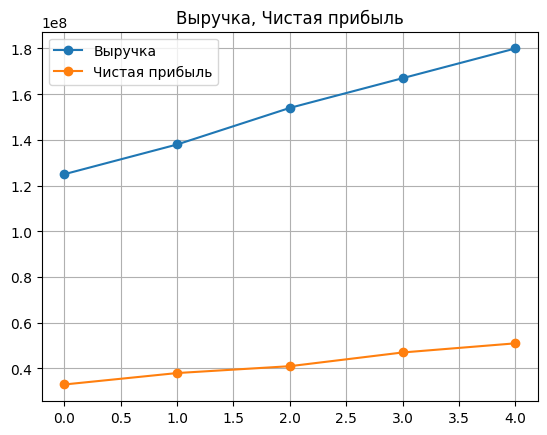

In [ ]:
fig

### Подготовка данных - выжимки из статей

In [ ]:
!pip install langchain_openai==0.3.0
!pip install langchain_community==0.3.14
!pip install chromadb==0.5.0
!pip install sentence_transformers==3.3.1
!pip install langchain_huggingface==0.1.2
!pip install langchain_chroma==0.2.0
!pip install langchain_core==0.3.29
!pip install pydantic==2.10.5
!pip install onnxruntime==1.20.1

In [ ]:
!pip install wikipedia beautifulsoup4

In [ ]:
from langchain_community.document_loaders import (
    WikipediaLoader,
    WebBaseLoader,
)
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
def split_docs(documents, chunk_size=1000, chunk_overlap=100):
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    return splitter.split_documents(documents)

In [ ]:
wiki_loader = WikipediaLoader(query="бизнес-аналитика", lang="ru")
wiki_docs = wiki_loader.load()
wiki_chunks = split_docs(wiki_docs)

/usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [ ]:
urls = [
    "https://www.forbes.ru/tegi/biznes-analitika",
    "https://www.it-world.ru/tag/bi/",
    "https://www.batimes.com/",
    "https://business-analytics-russia.ru/articles-for-business-analyst/",
    "https://www.dbta.com/Categories/Business-Intelligence-and-Analytics-327.aspx"
]

web_loader = WebBaseLoader(urls)
web_docs = web_loader.load()
web_chunks = split_docs(web_docs)

In [ ]:
all_chunks = wiki_chunks + web_chunks
print(f"Всего фрагментов: {len(all_chunks)}")
print(all_chunks[0].page_content[:1000])  # вывод примера содержимого

Всего фрагментов: 198
Бизнес-аналитик — специалист, использующий методы бизнес-анализа для исследования потребностей деятельности организаций с целью определения проблем бизнеса и предложения их решения.
Международный Институт Бизнес-Анализа (IIBA, International Institute of Business Analysis) определяет бизнес-аналитика «как посредника между заинтересованными лицами для сбора, анализа, коммуницирования и проверки требований по изменению бизнес-процессов, регламентов и информационных систем. Бизнес-аналитик понимает проблемы и возможности бизнеса в контексте требований и рекомендует решения, позволяющие организации достичь своих целей».
В консалтинговом бизнесе бизнес-аналитиком называется высшая позиция для консультанта.
IIBA отмечает всемирный день бизнес-анализа 1-го ноября


== См. также ==
Аналитическая записка
SWOT-анализ
PEST-анализ
Анализ пяти сил Портера


In [ ]:
from langchain.chains.summarize import load_summarize_chain
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from google.colab import userdata

llm = ChatOpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=userdata.get('OPENROUTER_KEY'),
    model_name="gpt-3.5-turbo"
)

prompt_template = """Напиши краткое содержание следующего текста на английском языке:

{text}

КРАТКОЕ СОДЕРЖАНИЕ НА АНГЛИЙСКОМ:"""
PROMPT = ChatPromptTemplate.from_template(prompt_template)

def summarize_chunks(chunks):
    chain = load_summarize_chain(
        llm,
        chain_type="map_reduce",
        map_prompt=PROMPT,
        combine_prompt=PROMPT
    )
    return chain.run(chunks)

summary = summarize_chunks(all_chunks[:10])
print(summary)

A business analyst is a specialist who investigates the needs of organizations, identifies business problems, and proposes solutions. Analytics is the systematic analysis of data to identify patterns and make strategic decisions. Aristotle and Immanuel Kant made early contributions to the field. Marketing analytics involves gathering and analyzing data on customer purchases and survey responses to make strategic decisions. Web analytics allows marketers to optimize marketing campaigns and website content. Human resource analytics is used in talent management and forecasting changes in the workforce. Business intelligence involves translating business information into a human-readable format for decision-making. BI supports a wide range of business decisions from operational to strategic.


In [ ]:
with open("summaries_eng.txt", "w", encoding="utf-8") as f:
    for i, doc in enumerate(all_chunks):
        f.write(f"--- Document {i} ---\n")
        summary = summarize_chunks([doc])
        f.write(summary + "\n\n")

In [ ]:
prompt_template = """Напиши краткое содержание следующего текста на русском языке:

{text}

КРАТКОЕ СОДЕРЖАНИЕ НА РУССКОМ:"""
PROMPT = ChatPromptTemplate.from_template(prompt_template)

summary = summarize_chunks(all_chunks[:10])
print(summary)

 Бизнес-аналитик — специалист, обеспечивающий сбор, анализ, коммуникацию и проверку требований к изменению бизнес-процессов, регламентов и информационных систем. Он помогает организациям решать бизнес-проблемы и достигать своих целей. Аналитика — систематический численный анализ данных или операция по расчленению целого на составные части, применяемая частыми в областях с большим накоплением информации. Аналитика обычно подразделяется на описательную, диагностическую, прогнозную, предписывающую и когнитивную. В тексте также приведены краткие сведения о различных видах аналитики, таких как маркетинговая аналитика, веб-аналитика, управление персоналом (HR-аналитика) и бизнес-интеллектуальная система (BI). BI эффективен, если объединяет внешние и внутренние данные, получая более полную картину бизнеса. Международный день бизнес-анализа отмечается 1 ноября.


In [ ]:
with open("summaries_ru.txt", "w", encoding="utf-8") as f:
    for i, doc in enumerate(all_chunks):
        f.write(f"--- Document {i} ---\n")
        summary = summarize_chunks([doc])
        f.write(summary + "\n\n")

### Работа с выжимками

`parse_documents(text)` - разбивает файл с описаниями статей на словарь вида {Document N: текст}.

In [ ]:
def parse_documents(text):
    pattern = r"--- (Document \d+) ---\n(.*?)(?=(?:--- Document \d+ ---|\Z))"
    matches = re.findall(pattern, text, re.DOTALL)
    return {doc_id: content.strip() for doc_id, content in matches}

In [ ]:
with open('summaries_eng.txt','r') as f:
    text=f.read()
parse_documents(text)

{'Document 0': "A business analyst is a specialist who investigates organizations' needs, identifies problems, and proposes solutions. They act as intermediaries between stakeholders, analyzing and communicating requirements for changing business processes and systems. The role is defined by the International Institute of Business Analysis as crucial for helping organizations achieve their goals, and in consulting, it is a senior consultant position. World Business Analysis Day is celebrated on November 1st.",
 'Document 1': 'Analytica is the process of analyzing and breaking down a whole into its constituent parts through cognitive or practical human activity.',
 'Document 2': 'Analytics is a methodical approach to analyzing numerical data to uncover patterns and insights, using statistics, computer programming, and operations research. It is used in various fields such as marketing, finance, and cybersecurity to make informed decisions and solve complex problems by processing large d

In [ ]:
with open('summaries_ru.txt','r') as f:
    text=f.read()
parse_documents(text)

{'Document 0': "Бизнес-аналитик - специалист, применяющий методы бизнес-анализа для исследования потребностей деятельности организаций с целью определения проблем бизнеса и предложений их решения. Международный Институт Бизнес-Анализа (IIBA) определяет бизнес-аналитика как посредника для сбора, анализа, коммуникации и проверки требований к изменению бизнес-процессов, правил и информационных систем. Как высококвалифицированный консалтинг-специалист, бизнес-аналитик понимает проблемы и возможности бизнеса в контексте требований и рекомендует решения, позволяющие организации достичь своих целей. IIBA отмечает всемирный день бизнес-анализа 1-го ноября. Автор использовал термины 'Аналитическая записка', 'SWOT-анализ', 'PEST-анализ', 'Анализ пяти сил Портера', чтобы обозначить различные методы бизнес-анализа.",
 'Document 1': 'Аналитика - это часть искусства рассуждений или логики, затрагивающая учение о разборе целого на составляющие части при познании или предметно- практической деятельнос

поиск релевантных документов по вопросу пользователя

In [ ]:
def search(question, db):
    with open(db,'r') as text:
        t=text.read()
    messages = [
        {
            "role": "system",
            "content": """Ты — аналитик данных. Твоя задача — помочь пользователю найти подходящие статьи на основе его запроса.

Тебе предоставлен документ, содержащий список файлов с кратким описанием (выжимкой) содержания каждой статьи.

Что нужно сделать:
1. Проанализируй вопрос пользователя.
2. Сравни смысл запроса с содержанием каждой статьи.
3. Верни список названий тех документов, которые наиболее соответствуют запросу.
4. Если подходящих документов нет — верни пустой список: []

Формат ответа:
['<filename>', '<filename>', ...]

Дополнительно:
- Статьи и запрос могут быть на разных языках — учитывай смысл, а не язык.
- Не добавляй пояснений, комментариев или другого текста — только список файлов.
"""
        },
        {
            "role": "user",
            "content": f"""Вот база документов:

{t}

Вопрос пользователя:
"{question}"
"""
        }
    ]

    return ast.literal_eval((ask_gemma_simple(m=messages).strip()))


In [ ]:
import re

def get_documents_by_ids(doc_ids, db_path='summaries_ru.txt'):
    with open(db_path, 'r', encoding='utf-8') as f:
        text = f.read()

    results = {}
    for doc_id in doc_ids:
        pattern = rf"--- {re.escape(doc_id)} ---\n(.*?)(?=\n--- Document \d+ ---|\Z)"
        match = re.search(pattern, text, re.DOTALL)
        if match:
            results[doc_id] = match.group(1).strip()
        else:
            results[doc_id] = f"Документ {doc_id} не найден."

    return results

Аналитика - это междисциплинарная область, часто называемая расширенной аналитикой, использующая методы машинного обучения, нейронных сетей и регрессионного анализа. Она включает неконтролируемые методы машинного обучения, такие как кластерный анализ, анализ главных компонент профиля сегментации и анализ ассоциаций. В данном тексте нет информации о приложениях.


In [ ]:
res = search("Найди в базе информацию об определении слова веб-аналитика", "summaries_ru.txt")
res

['Document 6']


In [ ]:
documents = get_documents_by_ids(res)

for doc_id, content in documents.items():
    print(f"'{doc_id}': {content}\n")

'Document 6': Веб-аналитика - это процесс сбора данных о действиях посетителей веб-сайта во время сеанса с целью улучшения маркетинговых кампаний и структуры веб-сайта. Данные полученные при этом могут использоваться для оптимизации торгового персонала, сегментирования аудитории, моделирования маркетинговых комплексов и анализа информации о ценообразовании и продвижении. Веб-аналитика дополняет традиционные методы маркетингового анализа и обеспечивает оптимизацию веб-сайтов и онлайн-кампаний.



In [ ]:
res = search("Найди в базе информацию об определении слова аналитика", "summaries_eng.txt")
res

['Document 1', 'Document 4']


In [ ]:
documents = get_documents_by_ids(res, 'summaries_eng.txt')

for doc_id, content in documents.items():
    print(f"'{doc_id}': {content}\n")

Document 1: Analytica is the process of analyzing and breaking down a whole into its constituent parts through cognitive or practical human activity.
Document 4: Analytics is an interdisciplinary field that uses methods such as machine learning and neural networks. It also includes unsupervised machine learning methods like cluster analysis and principal component analysis for segmentation profiling.


### Работа с PDF


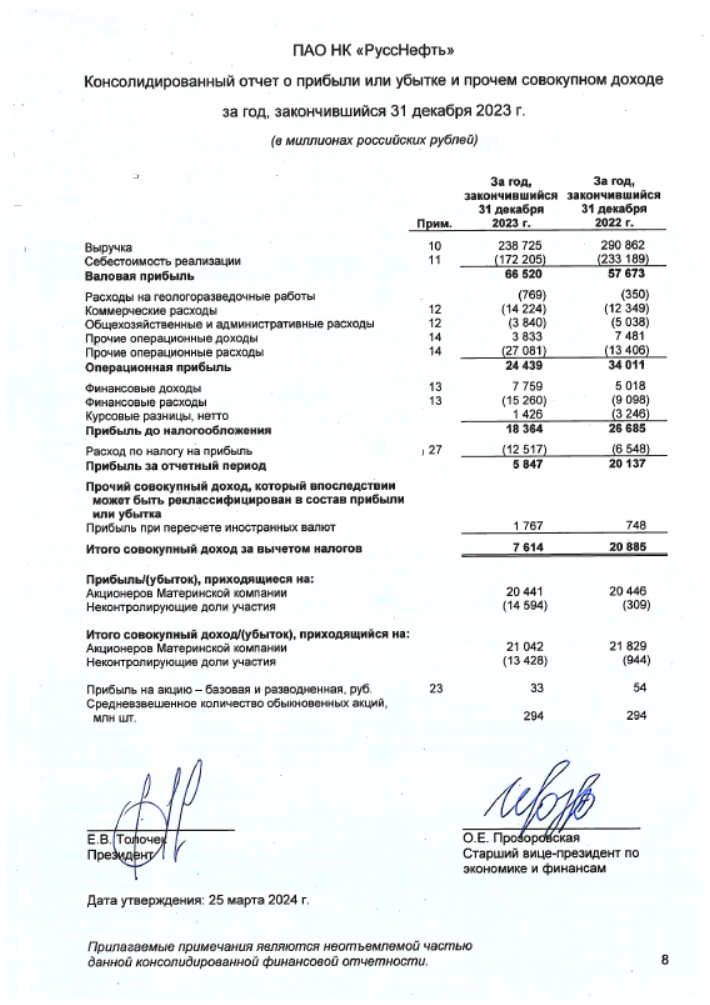

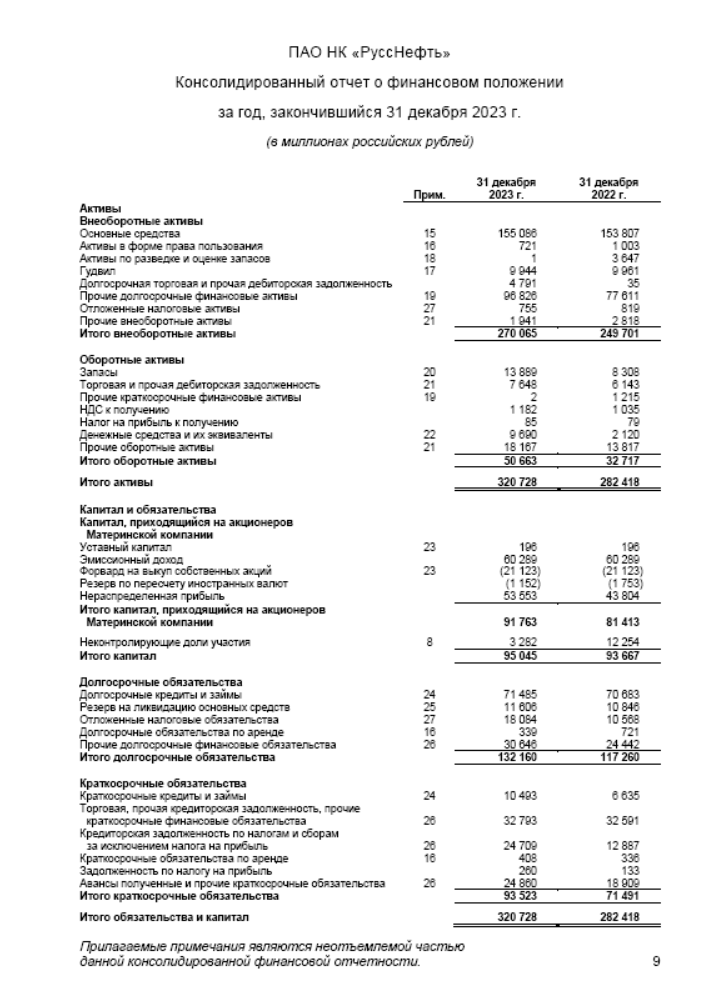

извлекаю сожержимое pdf

In [ ]:
def extract_text_from_pdf(path: str) -> str:
    doc = fitz.open(path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text
pdf_path = "test_report.pdf"
document_text = extract_text_from_pdf(pdf_path)
print(document_text[:4000])

ПАО НК «РуссНефть» 
 
Консолидированный отчет о финансовом положении
 
за год, закончившийся 31 декабря 2023 г. 
 
(в миллионах российских рублей) 
 
 
Прилагаемые примечания являются неотъемлемой частью
данной консолидированной финансовой отчетности. 
9 
Прим. 
31 декабря  
2023 г. 
31 декабря 
2022 г. 
Активы  
 
 
Внеоборотные активы 
 
 
Основные средства 
15 
155 086 
153 807
Активы в форме права пользования 
16 
721 
1 003
Активы по разведке и оценке запасов 
18 
1 
3 647
Гудвил  
17 
9 944 
9 961
Долгосрочная торговая и прочая дебиторская задолженность 
 
4 791 
35
Прочие долгосрочные финансовые активы 
19 
96 826 
77 611
Отложенные налоговые активы 
27 
755 
819
Прочие внеоборотные активы 
21 
1 941 
2 818
Итого внеоборотные активы 
 
270 065 
249 701
 
 
 
Оборотные активы 
 
 
Запасы 
20 
13 889 
8 308
Торговая и прочая дебиторская задолженность 
21 
7 648 
6 143
Прочие краткосрочные финансовые активы 
19 
2 
1 215
НДС к получению 
 
1 182 
1 035
Налог на прибыль к получению 

In [ ]:
def ask_with_context_pdf(message,context=None):
    need_df=0
    err=0
    messages = [
        {"role": "system", "content": "Ты — ассистент по бизнес-аналитике. Отвечай строго по предоставленному тексту. Если в нём есть числовые или табличные данные (например, финансовая отчётность или временные ряды), обязательно в конце добавь один валидный блок <json>...</json> с данными, которые можно напрямую загрузить в pandas.DataFrame.\n\nФормат JSON должен соответствовать следующим требованиям:\n\n1. Используй только **один блок <json>...</json>**.\n2. Структура — **таблица**: список словарей, где каждый словарь — это строка таблицы, а ключи — названия колонок (например: \"Показатель\", \"2022\", \"2023\").\n3. **Все значения должны быть числовыми (int или float), кроме названий показателей.**\n4. **Каждое поле должно иметь чёткий ключ.** Нельзя писать `{\"Показатель\": \"2022\", \"2023\"}` — так невалидно.\n5. Не используй обратные кавычки, markdown, пояснения или текст внутри блока <json>.\n\nПример правильной структуры:\n<json>\n{\n  \"Баланс\": [\n    {\"Показатель\": \"Активы\", \"2022\": 282418, \"2023\": 320728},\n    {\"Показатель\": \"Внеоборотные активы\", \"2022\": 249701, \"2023\": 270065},\n    {\"Показатель\": \"Оборотные активы\", \"2022\": 32717, \"2023\": 50663}\n  ]\n}\n</json>\n\nТакая структура позволяет сразу преобразовать JSON в DataFrame для дальнейшего анализа."},
        {"role": "user", "content": f"Вот часть текста документа:\n{context}"},
        {"role": "system","content": "Если документа нет, то отвечай не по содержанию а просто, так же можешь отвечать на общеизвестные вопросы дже если ответов нет в документе"},
        {"role": "user", "content": f"Вопрос: {message}"}
    ]
    response = client.chat.completions.create(
        model="gemma:3-12b-it-qat",
        messages=messages,
        temperature=0.3,
        max_tokens=10_000
    )

    answer=response.choices[0].message.content


    need_df ='<json>' in answer
    ind=answer.find('<json>')
    if need_df:
        match = re.search(r"<json>(.*?)</json>", answer, r.DOTALL)
        err = not match
        if err:
            return 'Произошла ошибка при формировании таблицы'
        raw_json = match.group(1).strip()
        cleaned=extract_and_send_json_for_fix(raw_json)
        parsed = clean_and_parse_json_block(cleaned)
        df = pd.DataFrame(parsed[list(parsed.keys())[0]])
        return answer[:ind],df
    else:
        return answer


In [ ]:
context = document_text
question = "Сделай ключевые выводы исходя из отчета"
answer = ask_with_context_pdf(question, context)

print("Ответ от Gemma:\n", answer[0])

Ответ от Gemma:
 Согласно консолидированному отчету о финансовом положении ПАО НК «РуссНефть» за год, закончившийся 31 декабря 2023 г., можно сделать следующие ключевые выводы:

*   **Рост активов:** Общие активы компании увеличились с 282 418 миллионов рублей на 31 декабря 2022 года до 320 728 миллионов рублей на 31 декабря 2023 года. Это свидетельствует о расширении деятельности компании.
*   **Увеличение внеоборотных активов:** Внеоборотные активы выросли с 249 701 миллиона рублей до 270 065 миллионов рублей, что обусловлено в основном ростом основных средств и прочих долгосрочных финансовых активов.
*   **Рост оборотных активов:** Оборотные активы также увеличились, с 32 717 миллионов рублей до 50 663 миллионов рублей. Значительный рост наблюдается по запасам и торговой дебиторской задолженности.
*   **Увеличение капитала:** Капитал, приходящийся на акционеров материнской компании, увеличился с 81 413 миллионов рублей до 91 763 миллионов рублей в основном за счет увеличения нераспр

In [ ]:
display(answer[1])

,Год,Внеоборотные активы,Оборотные активы,Активы
0,2022,249701.0,NaN,NaN
1,2023,270065.0,NaN,NaN
2,2022,NaN,32717.0,NaN
3,2023,NaN,50663.0,NaN
4,2022,NaN,NaN,282418.0
5,2023,NaN,NaN,320728.0


Вспомогательные функции:

`extract_local_pdf_links(text)` - ищет в тексте локальные ссылки на PDF-файлы. Используется, чтобы понять, не содержит ли контекст файл.


`context_handle(context)` - если в контексте найдена ссылка на PDF, извлекает его текст, иначе возвращает исходный контекст.

`parse_call_search(text)` - ищет в тексте намерения - метки < CALL> /< SEARCH>, чтобы понять, нужно ли строить график (CALL=1) и/или искать статьи (SEARCH=1).



In [ ]:
def extract_local_pdf_links(text):
    pattern = r'(?<!https:)(?<!http:)(?<!mailto:)(?<!//)(?<![\w:/])(?:\.?/)?(?:[\w\-/\\]+)?[\w\-]+\.pdf'
    return re.findall(pattern, text, re.IGNORECASE)

def context_handle(context):
    a= extract_local_pdf_links(text)
    if len(a) == 0:
        return context
    else:
        return extract_text_from_pdf(a[0])[:3500]

def parse_call_search(text):
    match = re.search(r"<CALL>\s*=\s*(\d)\s*<SEARCH>\s*=\s*(\d)", text)
    if match:
        ca = int(match.group(1))
        se = int(match.group(2))
        return ca, se
    else:
        return None, None

### Основная функция обработки сообщений

Это ключевая функция системы, которая:

1. Инициализирует структуру для ответа

2. Обрабатывает контекст (извлекает текст из PDF при необходимости)

3. Определяет намерения пользователя (< CALL> и < SEARCH>)

4. Получает ответ от модели с учетом контекста

5. При необходимости:

  - Строит график (если < CALL> = 1)

  - Ищет документы (если < SEARCH> = 1)

6. Форматирует и выводит ответ

In [ ]:
from IPython.display import display

In [ ]:
def merge_files(file_paths, output_path):
    with open(output_path, 'w', encoding='utf-8') as out:
        for file_path in file_paths:
            with open(file_path, 'r', encoding='utf-8') as f:
                out.write(f.read())
                out.write('\n')

merge_files(['summaries_eng.txt', 'summaries_ru.txt'], 'summaries.txt')

In [ ]:
db_1=parse_documents(text)
db='summaries.txt'

In [ ]:
def one_mesasge(message, context='  '):
    final={'answer':None,'pic':None,'search':None}
    link=extract_local_pdf_links(context)
    if link:
        c=extract_text_from_pdf(link[0])[:3500]
    else:
        c= context
    a = get_intent(message)
    ca,se=parse_call_search(a)
    try:
        answer,df= ask_with_context(message,context=c)
    except:
        answer= ask_with_context(message,context=c)
    final['answer']=answer
    if ca:
        _,pic=call(df,message)
        final['pic']=pic
    if se:
        res=search(message, db)
        final['search']=res[0]

    p1=f"Ответ модели на вопрос: {final['answer']} \n"
    print(p1)

    if final['search']:
        print(final['search'])
        print(db_1[final['search']])
    if final['pic']:
        display(pic)

Работа с текстовой информацией, построение графика и поиск ответа с базы данных:

Ответ модели на вопрос: К сожалению, предоставленный текст не содержит информации об истории слова "аналитик". Он описывает финансовые показатели компании "Альфа Тех" за 2019-2023 годы.

По данным текста, динамика прибыли и расходов выглядит следующим образом:

*   **Выручка:** 125 млн (2019), 138 млн (2020), 154 млн (2021), 167 млн (2022), 180 млн (2023)
*   **Расходы:** 92 млн (2019), 100 млн (2020), 113 млн (2021), 120 млн (2022), 129 млн (2023)
*   **Чистая прибыль:** 33 млн (2019), 38 млн (2020), 41 млн (2021), 47 млн (2022), 51 млн (2023)

 

Document 3
The term "analytic" has a long history, dating back to Aristotle's use in the 4th century BCE to describe logic, and was later referenced by Immanuel Kant in the 18th century to describe the breakdown of human cognitive abilities.


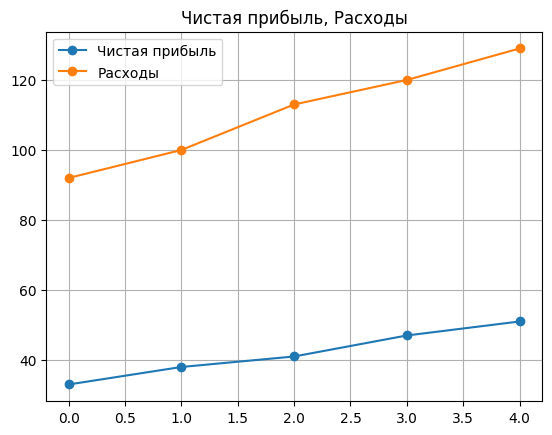

In [ ]:
one_mesasge("Найди мне информацию про историю слова аналитик и построй график прибыли и расходов компании", context=test_p)

Работа с информацией из PDF-файла

In [ ]:
one_mesasge("Проанализируй результаты и дай реккомендации, коротко 5 предложний", context=document_text)

Ответ модели на вопрос: Активы ПАО НК «РуссНефть» увеличились с 282 418 млн руб. в 2022 г. до 320 728 млн руб. в 2023 г., что свидетельствует о росте бизнеса. Основной вклад в увеличение активов внесли прочие долгосрочные финансовые активы и основные средства. Капитал компании также увеличился, но менее значительно, чем активы, что может указывать на необходимость привлечения дополнительного финансирования для поддержания темпов роста.  В то же время, долгосрочные обязательства выросли больше, чем краткосрочные, что требует внимания к управлению финансовым риском и обеспечению достаточной ликвидности. Рекомендуется провести более детальный анализ структуры активов и обязательств для оптимизации финансовой устойчивости компании.

 



### Основной цикл диалоговой системы

реализуется интерактивный режим работы с пользователем

- в цикле запрашивается вопросы и контекст

- для каждого запроса вызывается `one_message()`

завершается при вводе 'q'

In [ ]:
def main():
    message = input('Введите ваш вопрос (для выхода введите q)')
    context= input('Введите контекст (текст или путь к pdf)')
    while message!='q':
        one_mesasge(message, context=context)
        print('-'*50)
        print('-'*50)
        message = input('Введите ваш вопрос (для выхода введите q)')
        context= input('Введите контекст (текст или путь к pdf)')

Введите ваш вопрос (для выхода введите q) 12 умножить на 20
Введите контекст (текст или путь к pdf) 


Ответ модели на вопрос: 12 умножить на 20 равно 240. 

--------------------------------------------------
--------------------------------------------------


Введите ваш вопрос (для выхода введите q) Найди мне информацию про историю слова аналитик и построй график прибыли и расходов компании
Введите контекст (текст или путь к pdf) Финансовый отчёт компании "Альфа Тех" за 2019–2023 гг. показывает устойчивый рост. Выручка компании увеличивалась ежегодно: в 2019 году она составила 125 млн рублей, в 2020 — 138 млн, в 2021 — 154 млн, в 2022 — 167 млн, в 2023 — 180 млн рублей.  Расходы за тот же период: 2019 — 92 млн, 2020 — 100 млн, 2021 — 113 млн, 2022 — 120 млн, 2023 — 129 млн рублей.  Чистая прибыль по годам: 2019 — 33 млн, 2020 — 38 млн, 2021 — 41 млн, 2022 — 47 млн, 2023 — 51 млн рублей.  Капитализация на конец 2023 года достигла 750 млн рублей. В компании отмечают рост маржи и снижение долговой нагрузки


Ответ модели на вопрос: К сожалению, в предоставленном тексте нет информации об истории слова "аналитик". Текст содержит только финансовые данные компании "Альфа Тех" за 2019–2023 гг.

Что касается графика прибыли и расходов, я могу предоставить информацию о них из текста:

*   **Выручка:** 125 млн (2019), 138 млн (2020), 154 млн (2021), 167 млн (2022), 180 млн (2023)
*   **Расходы:** 92 млн (2019), 100 млн (2020), 113 млн (2021), 120 млн (2022), 129 млн (2023)
*   **Чистая прибыль:** 33 млн (2019), 38 млн (2020), 41 млн (2021), 47 млн (2022), 51 млн (2023) 

Document 3
The term "analytic" has a long history, dating back to Aristotle's use in the 4th century BCE to describe logic, and was later referenced by Immanuel Kant in the 18th century to describe the breakdown of human cognitive abilities.


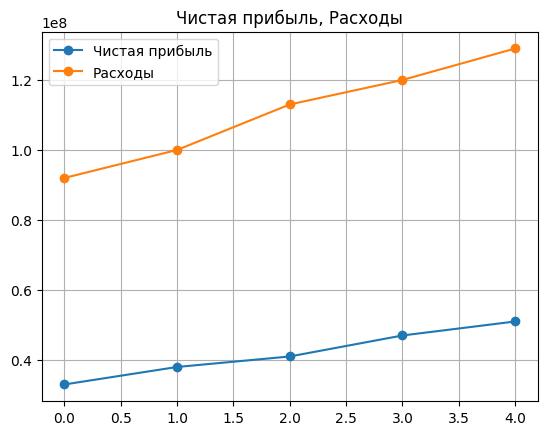

--------------------------------------------------
--------------------------------------------------


Введите ваш вопрос (для выхода введите q) q
Введите контекст (текст или путь к pdf) 


In [ ]:
main()

### Простой пример с облачной OpenAI моделью `gpt-3.5-turbo`

In [ ]:
HF_TOKEN=userdata.get('OPENROUTER_KEY')

In [ ]:
from huggingface_hub import InferenceClient
client = InferenceClient(token=HF_TOKEN)

In [ ]:
def ask_inference_api(prompt, sys_prompt=None, context_messages=None, model="gpt-3.5-turbo"):
    if sys_prompt:
        full_prompt = f"<<SYS>>\n{sys_prompt}\n<</SYS>>\n"
    else:
        full_prompt = ""

    if context_messages:
        for msg in context_messages:
            role = msg["role"]
            content = msg["content"]
            if role == "user":
                full_prompt += f"[INST] {content} [/INST]\n"
            elif role == "assistant":
                full_prompt += f"{content}\n"

    full_prompt += f"[INST] {prompt} [/INST]"
    formatted_prompt = f"<s>{full_prompt}</s>"

    response = client.text_generation(
        prompt=formatted_prompt,
        model=model,
        max_new_tokens=500,
        temperature=0.7,
        return_full_text=False
    )

    return response

In [ ]:
response = ask_inference_api(
    prompt="Объясни, почему Луна не падает на Землю. коротко 2 предложения",
)
print(response)

The moon does not fall to the Earth because it is in a state of continuous free fall, constantly missing the Earth due to its tangential velocity. This results in a stable elliptical orbit around the Earth, as described by the laws of gravitation and motion.


In [ ]:
response = ask_inference_api(
    prompt="ПРОАНАЛИЗИРУЙ ОТЧЕТ СДЕЛАЙ ВЫВОДЫ И ДАЙ СОВЕТЫ",
    context_messages=[
        {
            "role": "user",
            "content": '''Финансовый отчёт компании "Альфа Тех" за 2019–2023 гг. показывает устойчивый рост. Выручка компании увеличивалась ежегодно: в 2019 году она составила 125 млн рублей, в 2020 — 138 млн, в 2021 — 154 млн, в 2022 — 167 млн, в 2023 — 180 млн рублей. Расходы за тот же период: 2019 — 92 млн, 2020 — 100 млн, 2021 — 113 млн, 2022 — 120 млн, 2023 — 129 млн рублей. Чистая прибыль по годам: 2019 — 33 млн, 2020 — 38 млн, 2021 — 41 млн, 2022 — 47 млн, 2023 — 51 млн рублей. Капитализация на конец 2023 года достигла 750 млн рублей. В компании отмечают рост маржи и снижение долговой нагрузки.'''
        }
    ],
    sys_prompt="Ты — ассистент по бизнес-аналитике."
)

print(response)


Based on the financial report of Alpha Tech, the company has shown a steady growth over the years 2019-2023. The revenue has consistently increased from 125 million rubles in 2019 to 180 million rubles in 2023, representing an annual growth rate of approximately 11.6%. This is a positive sign, indicating that the company's products or services are in demand and that the company is effectively expanding its customer base or increasing sales to existing customers.

The company's expenses have also increased over the same period, but at a slower rate than revenue. This has resulted in a steady increase in net profit, from 33 million rubles in 2019 to 51 million rubles in 2023. This represents an annual growth rate of approximately 12.1%, which is higher than the growth rate of revenue. This is a good sign, as it indicates that the company is becoming more efficient in controlling costs, which leads to higher profits.

The company's capitalization has also increased significantly, reaching

In [ ]:
response = ask_inference_api(
    prompt="ПРОАНАЛИЗИРУЙ ОТЧЕТ СДЕЛАЙ ВЫВОДЫ И ДАЙ СОВЕТЫ, ОТВЕЧАЙ НА РУССКОМ",
    context_messages=[
        {
            "role": "user",
            "content": '''Финансовый отчёт компании "Альфа Тех" за 2019–2023 гг. показывает устойчивый рост. Выручка компании увеличивалась ежегодно: в 2019 году она составила 125 млн рублей, в 2020 — 138 млн, в 2021 — 154 млн, в 2022 — 167 млн, в 2023 — 180 млн рублей. Расходы за тот же период: 2019 — 92 млн, 2020 — 100 млн, 2021 — 113 млн, 2022 — 120 млн, 2023 — 129 млн рублей. Чистая прибыль по годам: 2019 — 33 млн, 2020 — 38 млн, 2021 — 41 млн, 2022 — 47 млн, 2023 — 51 млн рублей. Капитализация на конец 2023 года достигла 750 млн рублей. В компании отмечают рост маржи и снижение долговой нагрузки.'''
        },
    ],
    sys_prompt="Ты — ассистент по бизнес-аналитике."
)

print(response)

Анализируя финансовый отчет компании "Альфа Тех", можно сделать следующие выводы:

1. Выручка компании увеличивается ежегодно с 2019 по 2023 год, что говорит о стабильном росте и увеличении объема бизнеса.

2. Рост выручки сопровождается увеличением расходов, но в целом расходы в каждом году покрываются выручкой, приводя к положительной чистой прибыли.

3. Маржа прибыли по годам также растет, что свидетельствует о повышении эффективности бизнеса.

4. Снижение долговой нагрузки может быть связано с повышением ликвидности компании, поскольку она может увеличивать свой капитал за счет профицита или понизить длительность задолженностей.

5. Капитализация компании на конец 2023 года достигла 750 млн рублей, что говорит о положительном развитии бизнеса и увеличении его стоимости.

Выводы: У компании "Альфа Тех" наблюдается стабильный рост выручки и чистой прибыли, повышение эффективности бизнеса, а также снижение долговой нагрузки.

Рекомендации:

1. Для дальнейшего развития компании необход

### __Заключение__

В рамках данной работы была разработана и реализована автоматическая диалоговая система, способная эффективно взаимодействовать с пользователем на естественном языке в сфере бизнес-аналитики. Система обеспечивает извлечение данных из текстов и PDF-документов, формирует структурированные таблицы, визуализирует показатели и осуществляет семантический поиск по базе аналитических статей.

Для обработки запросов и генерации ответов была выбрана языковая модель Gemma 3-12B IT-QAT, которая показала высокую точность, надёжность и способность решать прикладные аналитические задачи локально. Также использовалась облегчённая версия Gemma 2B — как альтернатива для менее ресурсоёмкой работы. Для сравнения качества использовалась облачная модель GPT-3.5-turbo, что позволило оценить преимущества и ограничения различных архитектур.

Система не только автоматически обрабатывает числовые и текстовые данные, но и делает это в интерактивном режиме с возможностью построения графиков, обработки PDF-файлов и поиска релевантной информации по смыслу запроса.


__Итог работы:__

Разработанная интеллектуальная система подтверждает высокую актуальность использования языковых моделей в бизнес-аналитике. Она снижает порог входа в работу с данными, ускоряет принятие решений и демонстрирует потенциал частичной автоматизации аналитической работы. Полученные результаты могут быть основой для дальнейшего развития, включая интеграцию в корпоративные среды и расширение функциональности (например, генерацию отчётов или прогнозных моделей).
